# Chain animation
Analyse cosmological model posterior samples.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.5' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree, lax
jconfig.update("jax_enable_x64", True)
print(jdevices())

from functools import partial
# from getdist import plots
# from numpyro import infer

%matplotlib inline
%load_ext autoreload
%autoreload 2

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

[cuda(id=0)]


## Test

In [4]:
from montecosmo.utils import rg2cgh, rg2cgh2
norm = "backward"
# norm = "ortho"
# norm = "forward"
shape = 3*(4,)
k = shape[1]-1
# k = slice(k, None)

def foo1(rng):
    mesh = jr.normal(rng, shape)
    meshk = rg2cgh(mesh, norm=norm)
    return meshk

def foo2(rng):
    mesh = jr.normal(rng, shape)
    meshk = rg2cgh2(mesh, norm=norm)
    return meshk

n = 10000
meshes1 = jit(vmap(foo1))(jr.split(jr.key(46), n))
meshes2 = jit(vmap(foo2))(jr.split(jr.key(46), n))

meshes1.shape, meshes2.shape

2025-04-28 10:20:36.026029: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


((10000, 4, 4, 3), (10000, 4, 4, 3))

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/array.py:403: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


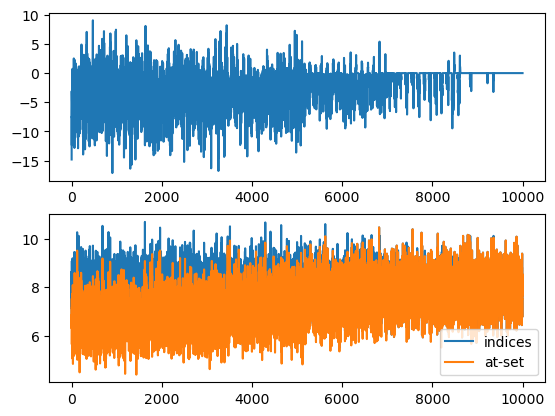

In [5]:
mses = ((meshes1 - meshes2)**2).mean(axis=(1,2,3))
mses1 = (meshes1).std(axis=(1,2,3))
mses2 = (meshes2).std(axis=(1,2,3))

plt.subplot(211) 
plt.plot(mses)
plt.subplot(212)
plt.plot(mses2, label="indices")
plt.plot(mses1, label="at-set")
plt.legend();

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, jit, vmap
jconfig.update("jax_enable_x64", True)

shape = 2*(8,)
k = shape[1]-1
# k = 1

def foo1(rng):
    mesh = jr.normal(rng, shape)
    mesh = mesh.at[0, 0].set(0)

    meshk = jnp.zeros(shape)
    meshk = meshk.at[:, k].set(mesh[:, k])
    return meshk

def foo2(rng):
    mesh = jr.normal(rng, shape)
    mesh = mesh.at[0,0].set(0)

    id = np.zeros((2, *shape), dtype=int)
    xyz = np.indices(shape, dtype=int)
    id[:,:,k] = xyz[:,:,k]

    meshk = mesh[tuple(id)]
    return meshk

n = 10000
meshes1 = jit(vmap(foo1))(jr.split(jr.key(46), n))
meshes2 = jit(vmap(foo2))(jr.split(jr.key(46), n))

meshes1.shape, meshes2.shape

((10000, 8, 8), (10000, 8, 8))

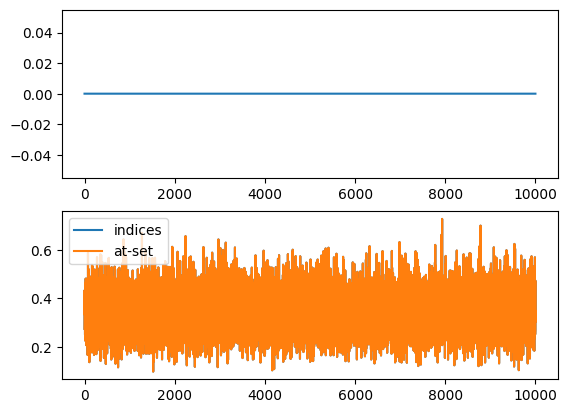

In [6]:
mses = ((meshes1 - meshes2)**2).mean(axis=(1,2))
mses1 = (meshes1).std(axis=(1,2))
mses2 = (meshes2).std(axis=(1,2))

plt.subplot(211) 
plt.plot(mses)
plt.subplot(212)
plt.plot(mses2, label="indices")
plt.plot(mses1, label="at-set")
plt.legend();

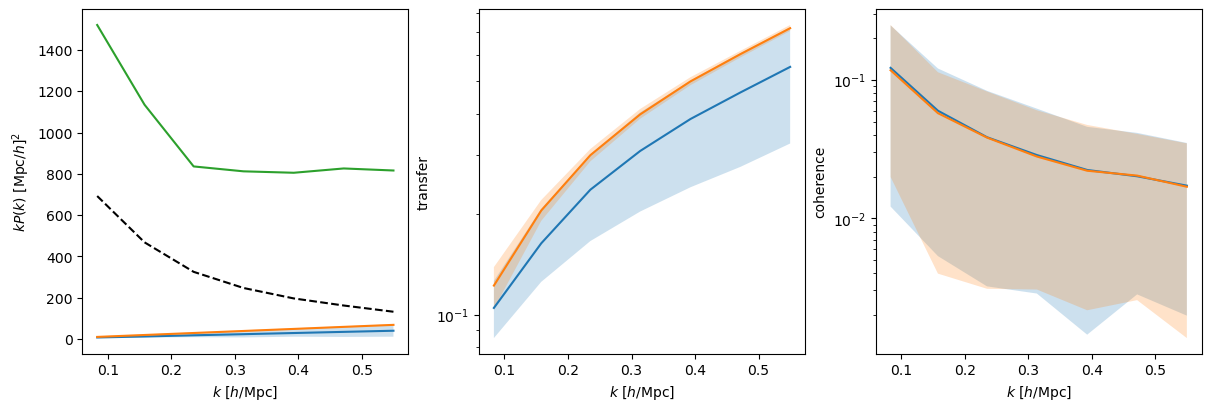

In [ ]:
# kptcs1 = vmap(lambda x: model.powtranscoh(mesh0, jnp.fft.irfftn(x)))(meshes1)
# kptcs2 = vmap(lambda x: model.powtranscoh(mesh0, jnp.fft.irfftn(x)))(meshes2)

# kptcs1 = (lambda x: model.powtranscoh(mesh0, jnp.fft.irfftn(x)))(meshes1)
# kptcs2 = (lambda x: model.powtranscoh(mesh0, jnp.fft.irfftn(x)))(meshes2)


prob = .95
pow_obs = model.spectrum(mesh_obs)

plt.figure(figsize=(12, 4), layout='constrained')
plot_powtranscoh(*kptcs1, fill=prob)
plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptcs1))
plot_powtranscoh(*kptcs2, fill=prob)
plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptcs2))
plt.subplot(131)
plot_pow(*pow_obs)
plot_pow(*model.spectrum(mesh0), '--k')

## Load

In [3]:
from montecosmo.chains import Chains
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme, SetDark2

save_dir = '/feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_ao0.5_evlpt_lo1_pckaiser_obfield/'
save_path = save_dir + 'sMCLMC_nc4_ns64'

# Load truth
print(f"Loading truth from {save_dir}")
truth = pload(save_dir+"truth.p")
model = FieldLevelModel(**default_config)
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
pow0 = model.spectrum(mesh0)
kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)
start = 2
end = 3

# Load chains
thinning = 1
transforms = [
            lambda x: x[['*~diverging']],
            partial(Chains.thin, thinning=thinning), 
            model.reparam_chains, 
            partial(model.powtranscoh_chains, mesh0=mesh0),
            # partial(Chains.choice, n=10, names=['init','init_']),
            ]
chains = model.load_runs(save_path, start, end, transforms=transforms, batch_ndim=2)
print(chains.shape)

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_ao0.5_evlpt_lo1_pckaiser_obfield/


2025-02-24 11:13:46.795205: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Loading: sMCLMC_nc4_ns64, from run 2 to run 3 (included)
{'Omega_m': (4, 128), 'b1': (4, 128), 'b2': (4, 128), 'bn2': (4, 128), 'bs2': (4, 128), 'init_mesh': (4, 128, 64, 64, 64), 'kptc': ((4, 128, 15), (4, 128, 15), (4, 128, 15), (4, 128, 15)), 'mse_per_dim': (4, 128), 'n_evals': (4, 128), 'sigma8': (4, 128)}


In [2]:
from montecosmo.chains import Chains
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_trans, plot_coh, theme, SetDark2

save_dir = '/feynman/home/dphp/hs276503/scratch/pickles/init/'
save_path = save_dir + 'sMCLMC_nc8_ns32'

# Load truth
print(f"Loading truth from {save_dir}")
truth = pload(save_dir+"truth.p")
# model = pload(save_dir+"model.p")
model = FieldLevelModel(**default_config | {'mesh_shape': 3*(128,), 'cell_length': 5., 'a_obs':0.5, 'box_center':(0,0,1), 'curved_sky': False})
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
pow0 = model.spectrum(mesh0)
kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)

init = pload(save_path+'_init_state.p')
init_last = pload(save_path+'_init_last_state.p').position
last0 = pload(save_path+'_0_last_state.p').position
last = pload(save_path+'_last_state.p').position

pth  = "/feynman/home/dphp/hs276503/scratch/pickles/evolution/m128_b640.0_ao0.5_evlpt_lo2_pckaiser_dyn_obfield/sMCLMC_nc8_ns32_chains.p"
chains = pload(pth)
kptcs_last = tree.map(jnp.concatenate, chains)['kptc']

mesh_obs0 = truth['obs'] - 1


Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/init/


2025-04-27 23:55:54.812264: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [24]:
from montecosmo.chains import Chains
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_trans, plot_coh, theme, SetDark2

model = FieldLevelModel(**default_config | {'mesh_shape': 3*(128,), 'cell_length': 5., 'a_obs':0.5, 
                                            'box_center':(0,0,1), 'curved_sky': False, 'evolution': 'lpt'})

truth = {'Omega_m': 0.3, 
        'sigma8': 0.8, 
        'b1': 1.,
        'b2':0., 
        'bs2':0., 
        'bn2': 0.}

truth = model.predict(samples=truth, hide_base=False, hide_samp=False, from_base=True)

mesh0 = jnp.fft.irfftn(truth['init_mesh'])
mesh_obs = truth['obs'] - 1

init_params = jit(vmap(partial(model.kaiser_post, delta_obs=truth['obs']-1, base=True)))(jr.split(jr.key(46), 100))
meshes = vmap(jnp.fft.irfftn)(init_params['init_mesh'])
kptcs = vmap(lambda x: model.powtranscoh(mesh0, jnp.fft.irfftn(x['init_mesh'])))(init_params)

vel: (Array(4.81988682, dtype=float64), Array(2.08041011, dtype=float64), Array(0.03312575, dtype=float64), Array(17.60383984, dtype=float64))


In [25]:
################
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
# kptcs__ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init)
kptcs__ = vmap(lambda x: model.powtranscoh(mesh0, jnp.fft.irfftn(x['init_mesh'])))(init_params)

kptcs_ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init | init_last)
kptcs = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(last)
kptcs0 = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(last0)
# kpk0 = model.spectrum(mesh0)
# kptc_obs = model.powtranscoh(mesh 0, truth['obs'] - 1)
# kpkobs = model.spectrum(truth['obs']-1)

print(init.keys(), init_last.keys(), last.keys())

dict_keys(['Omega_m_', 'b1_', 'b2_', 'bn2_', 'bs2_', 'init_mesh_', 'sigma8_']) dict_keys(['init_mesh_']) dict_keys(['Omega_m_', 'b1_', 'b2_', 'bn2_', 'bs2_', 'init_mesh_', 'sigma8_'])


In [26]:
from montecosmo.bricks import lin_power_interp, get_cosmology, lin_power_mesh
cosmo = get_cosmology(**model.loc_fid)
# powmesh = lin_power_mesh(cosmo, model.mesh_shape, model.box_size)
# mesh = jnp.fft.rfftn(jr.normal(jr.key(0), model.mesh_shape))
# mesh = jnp.fft.irfftn(mesh * powmesh**.5)
# kptcs_fiduc = model.powtranscoh(mesh0, mesh)

pow_fn = lin_power_interp(cosmo)
fiduc_trans = np.array((pow_fn(pow0[0]) / pow0[1])**.5)
trans = jnp.median(jnp.stack(kptcs_), 1)[2]
for i in range(15):
    fiduc_trans[i] = (fiduc_trans[i] - trans[i] ) / (15-i) * 3  + trans[i]
fiduc_trans = pow0[0], fiduc_trans

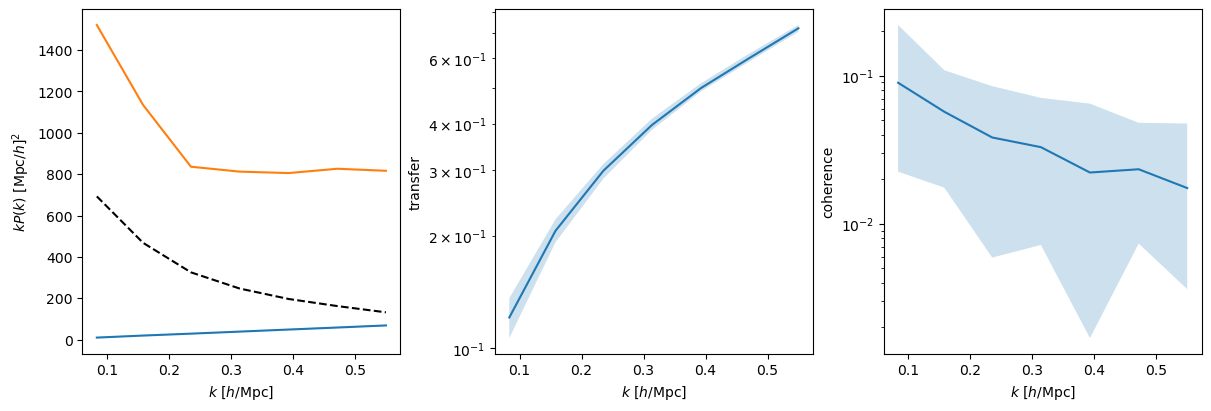

In [36]:
prob = .95
pow_obs = model.spectrum(mesh_obs)

plt.figure(figsize=(12, 4), layout='constrained')
plot_powtranscoh(*kptcs, fill=prob)
plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptcs))
plt.subplot(131)
plot_pow(*pow_obs)
plot_pow(*model.spectrum(mesh0), '--k')

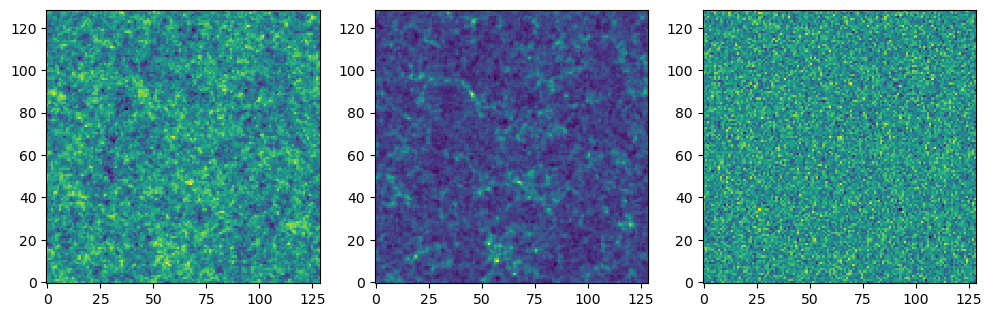

In [4]:
from montecosmo.plot import plot_mesh
plt.figure(figsize=(12, 5))
plt.subplot(131)
plot_mesh(mesh0, sli=5)
plt.subplot(132)
plot_mesh(meshes.mean(0), sli=5)
plt.subplot(133)
plot_mesh(meshes.std(0), sli=5)

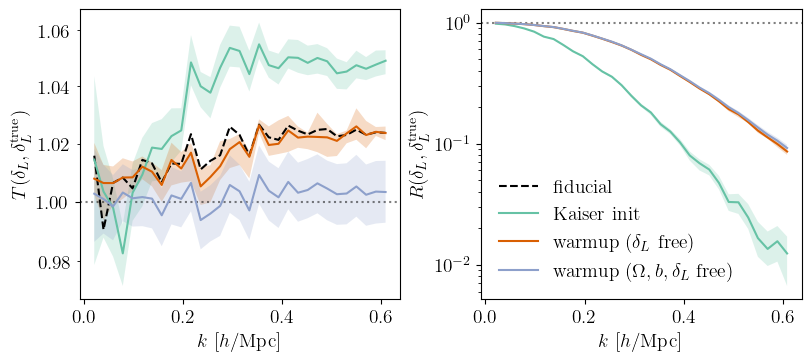

In [27]:
theme(usetex=True, font_size=14)
prob = 0.95
plt.figure(figsize=(8, 3.5), layout='constrained')
plt.subplot(121)
kptcs__med = jnp.median(jnp.stack(kptcs__), 1)
kptcs_med = jnp.median(jnp.stack(kptcs_), 1)
kptcs_last_med = jnp.median(jnp.stack(kptcs_last), 1)

plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_trans(*fiduc_trans, 'k--', label='fiduc')
plot_trans(kptcs__med[0], kptcs__med[2], label='Kaiser init')
plot_trans(kptcs__[0], kptcs__[2], fill=prob)
plot_trans(kptcs_med[0], kptcs_med[2], label='post warmup 1')
plot_trans(kptcs_[0], kptcs_[2], fill=prob)
plot_trans(kptcs_last_med[0], kptcs_last_med[2], label='post warmup 2')
plot_trans(kptcs_last[0], kptcs_last[2], fill=prob)

import matplotlib as mpl
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())

plt.ylabel('$T(\\delta_L, \\delta_L^\\mathrm{true})$')

plt.subplot(122)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.plot((), 'k--', label='fiducial')
plot_coh(kptcs__med[0], kptcs__med[3], label='Kaiser init')
plot_coh(kptcs__[0], kptcs__[3], fill=prob)
plot_coh(kptcs_med[0], kptcs_med[3], label='warmup ($\\delta_L$ free)')
plot_coh(kptcs_[0], kptcs_[3], fill=prob)
plot_coh(kptcs_last_med[0], (kptcs_last_med[3] - 1) * 0.993 + 1, label='warmup ($\\Omega, b, \\delta_L$ free)')
plot_coh(kptcs_last[0], (kptcs_last[3] - 1) * 0.993 + 1, fill=prob)
plt.legend(frameon=False)

plt.ylabel('$R(\\delta_L, \\delta_L^\\mathrm{true})$')


plt.savefig(f'initkai0.pdf', bbox_inches='tight')
# plt.savefig(f'init_glin_{task_id}.png')
################    

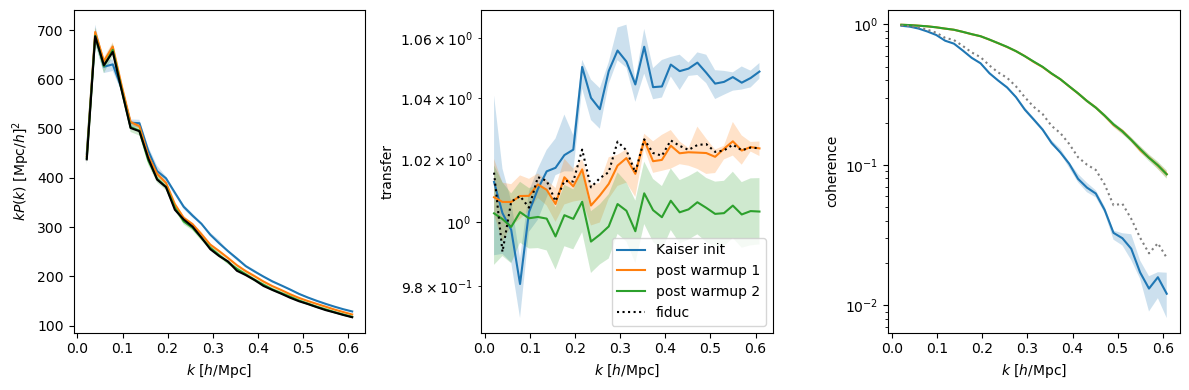

In [ ]:

prob = 0.95
plt.figure(figsize=(12, 4))
plot_powtranscoh(*jnp.median(jnp.stack(kptcs__), 1), label='Kaiser init')
plot_powtranscoh(*kptcs__, fill=prob)
plot_powtranscoh(*jnp.median(jnp.stack(kptcs_), 1), label='post warmup 1')
plot_powtranscoh(*kptcs_, fill=prob)
plot_powtranscoh(*jnp.median(jnp.stack(kptcs_last), 1), label='post warmup 2')
plot_powtranscoh(*kptcs_last, fill=prob)
plt.subplot(131)
plot_pow(*pow0, 'k', label='true')
plt.subplot(132)
plot_trans(*fiduc_trans, 'k:', label='fiduc')
# plot_pow(*kpkobs, ':', c='grey', label='obs')
plt.legend()
plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[-1], ':', c='grey', label='obs')
plt.tight_layout()
# plt.savefig(save_dir+f'initkai_{task_id}.png')
# plt.savefig(f'init_glin_{task_id}.png')
################    

## Anim

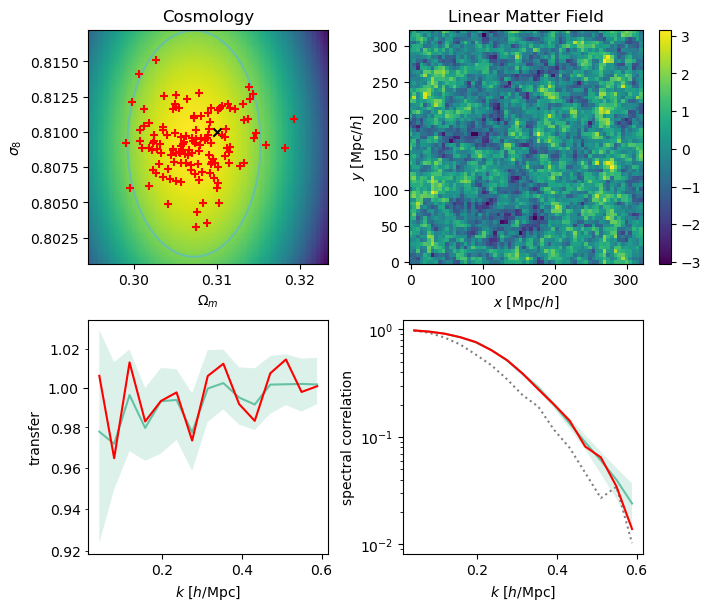

In [ ]:
from montecosmo.plot import plot_powtranscoh, plot_coh, plot_trans, plot_pow, plot_mesh, theme, mean_slice, plot_bivar
from montecosmo.utils import vlim
from sklearn.neighbors import KernelDensity
from matplotlib.animation import FuncAnimation
theme()

i_c = 0
i_plt = 10
sli = 0.1
log = False
prob = 0.95

plt.figure(figsize=(7, 6), layout='constrained')

plt.subplot(221)
xys = chains[i_c]['cosmo']
xy0 = Chains(truth, model.groups)['cosmo']
n_plt = len(xys[0])
lims = tree.map(partial(vlim, level=0.99, scale=1.5), xys)

kde = KernelDensity(kernel='gaussian', bandwidth='scott', atol=1e-5, rtol=1e-5)
xs = jnp.stack(xys).T
kde.fit(xs)
pdf = lambda x: jnp.exp(kde.score_samples(x))

# probs = np.array([0.68, 0.95, 0.997])
probs = np.array([0.95])
levels = jnp.quantile(pdf(xs), 1-probs[::-1])

plot_bivar(pdf, lims, n=100, type='mesh')
plot_bivar(pdf, lims, n=100, type='contour', colors=[SetDark2(0)], levels=levels, zorder=1)

xy = tree.map(lambda x: x[:i_plt], xys)
labels = [chains.labels[k] for k in chains.groups['cosmo']]

plt.scatter(*xy0, marker='x', color='k')
scat = plt.scatter(*xys, marker='+', color='r')
plt.xlabel(f'${labels[0]}$'), plt.ylabel(f'${labels[1]}$')
plt.xlim(lims[0]), plt.ylim(lims[1])
plt.title('Cosmology')


plt.subplot(222)
meshes = chains[i_c]['init']
mesh = meshes[i_plt]
quad1 = plot_mesh(mesh, model.box_size, sli=sli)
plt.title('Linear Matter Field')
plt.colorbar()


# plt.subplot(233)
# # diff = mesh - mesh0
# # quad2 = plot_mesh(diff, model.box_size, sli=sli, cmap='PRGn')
# stds = meshes.std(0)
# quad2 = plot_mesh(stds, model.box_size, sli=sli, cmap='viridis')
# plt.title('Linear Matter Field std')
# plt.colorbar()


kptcs = chains[i_c]['kptc']
kptc_med = tree.map(lambda x: jnp.median(x, 0), kptcs)
kptc = tree.map(lambda x: x[i_plt], kptcs)

plt.subplot(223)

plot_trans(kptc_med[0], kptc_med[2])
plot_trans(kptcs[0], kptcs[2], fill=prob)

line1 = plot_trans(kptc[0], kptc[2], log=log, color='r')[0]
import matplotlib as mpl
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())


plt.subplot(224)
plot_coh(kptc_med[0], kptc_med[3])
plot_coh(kptcs[0], kptcs[3], fill=prob)
plot_coh(kptc_obs[0], kptc_obs[3], ':', log=log, c='grey', label='obs')

line2 = plot_coh(kptc[0], kptc[3], log=log, color='r')[0]
# plt.ylabel('$| R(\\delta_L, \\delta_L^{\\rm{true}})|$')
plt.ylabel('spectral correlation')




def update(i):
    xy = tree.map(lambda x: x[:i], xys)
    scat.set_offsets(jnp.stack(xy).T)

    mesh = meshes[i]
    mesh2d = mean_slice(mesh, sli)
    quad1.set_array(mesh2d)
    # diff2d = mean_slice(mesh - mesh0, sli)
    # quad2.set_array(diff2d)

    kptc = tree.map(lambda x: x[i], kptcs)
    ks, pow, trans, coh = kptc
    # if not log:
    #     pow *= ks
    line1.set_data(ks, trans)
    line2.set_data(ks, coh)

    return scat, quad1, line1, line2

display(plt.gcf())
anim = FuncAnimation(plt.gcf(), update, frames=n_plt, interval=100, repeat_delay=1000, blit=True)
# anim.save("anim_chains.mp4")
display(anim)
plt.close()

## Plot

In [2]:
from montecosmo.chains import Chains
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_mesh, plot_trans, plot_coh, theme, SetDark2

save_dir = '/feynman/home/dphp/hs276503/scratch/pickles/evolution/m128_b640.0_ao0.5_evlpt_lo2_pckaiser_dyn_obfield/'
save_path = save_dir + 'sMCLMC_nc8_ns32'

# Load truth
print(f"Loading truth from {save_dir}")
truth = pload(save_dir+"truth.p")
# model = pload(save_dir+"model.p")
model = FieldLevelModel(**default_config | {'mesh_shape': 3*(128,), 'cell_length': 5.})
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
pow0 = model.spectrum(mesh0)
kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)

chlin = pload(save_path+'_chains_meshlinz5.p')
chobs = pload(save_path+'_chains_meshobsz5.p')
chbias = pload(save_path+'_chains_meshbias5.p')
chgxy = pload(save_path+'_chains_meshgxy5.p')
chgxytrue = pload(save_path+'_chains_meshgxytrue5.p')
chlin.shape, chobs.shape, chbias.shape, chgxy.shape, chgxytrue.shape

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/evolution/m128_b640.0_ao0.5_evlpt_lo2_pckaiser_dyn_obfield/


2025-04-30 15:00:01.048482: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


({'Omega_m': (8, 1920),
  'b1': (8, 1920),
  'b2': (8, 1920),
  'bn2': (8, 1920),
  'bs2': (8, 1920),
  'init_mesh': (8, 1920, 128, 128),
  'kptc': ((8, 1920, 31), (8, 1920, 31), (8, 1920, 31), (8, 1920, 31)),
  'mse_per_dim': (8, 1920),
  'n_evals': (8, 1920),
  'sigma8': (8, 1920)},
 {'kptc': ((8, 960, 31), (8, 960, 31), (8, 960, 31), (8, 960, 31)),
  'obs': (8, 960, 128, 128)},
 {'bias_mesh': (8, 960, 128, 128),
  'kptc': ((8, 960, 31), (8, 960, 31), (8, 960, 31), (8, 960, 31))},
 {'gxy_mesh': (8, 960, 128, 128),
  'kptc': ((8, 960, 31), (8, 960, 31), (8, 960, 31), (8, 960, 31))},
 {'gxy_mesh': (8, 960, 128, 128),
  'kptc': ((8, 960, 31), (8, 960, 31), (8, 960, 31), (8, 960, 31))})

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
from montecosmo.plot import SetDark2_k
theme(dark=True, usetex=True, font_size=18, cmap="SetDark2")

def scalarformatter(n):
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    if isinstance(n, int):
        plt.gca().yaxis.set_major_locator(mpl.ticker.MaxNLocator(n))
        plt.gca().yaxis.set_minor_locator(mpl.ticker.MaxNLocator(n))
    else:
        plt.gca().yaxis.set_major_locator(mpl.ticker.FixedLocator(n))
        plt.gca().yaxis.set_minor_locator(mpl.ticker.FixedLocator([]))
        

# Create a figure
i_plt = 0
fig = plt.figure(figsize=(9, 7.7))

gs23 = GridSpec(2, 2, figure=fig, wspace=0.35, hspace=0.3)
gs12_11 = gs23[0, 0:2].subgridspec(1, 2, wspace=-0.1)
gs12_21 = gs23[1, 0:2].subgridspec(1, 2, wspace=-0.1)

ax11 = fig.add_subplot(gs12_11[0])
plt.setp(ax11.get_xticklabels(), visible=False)
ax12 = fig.add_subplot(gs12_11[1], sharey=ax11)
plt.setp(ax12.get_yticklabels(), visible=False)
plt.setp(ax12.get_xticklabels(), visible=False)
# ax112.set_yticks([])

ax21 = fig.add_subplot(gs12_21[0])
ax22 = fig.add_subplot(gs12_21[1], sharey=ax21)
plt.setp(ax22.get_yticklabels(), visible=False)




# Linear matter field
sli = 1
log = False
prob = 0.95
meshes1 = jnp.concatenate(chlin['init'])
alpha = (1-prob)**.5
alpha = 0.5

plt.sca(ax11)
lim = 2.6
plot_mesh(mesh0, model.box_size, sli=5, axis=-2, vlim=(-lim, lim), cmap='viridis')
# plt.colorbar()
plt.xlabel(None)
plt.title('$ \\delta_L^\\mathrm{true}$', pad=10)

plt.sca(ax12)
means = meshes1[...,None][i_plt]
quad12 = plot_mesh(means, model.box_size, sli=sli, vlim=(-lim, lim), cmap='viridis')
plt.ylabel(None)
# plt.yticks([])
plt.xlabel(None)
plt.title('$\\delta_L$', pad=10)
plt.colorbar(ax=np.array([ax11, ax12]), pad=0.02, fraction=0.1)


# Galaxy density field
sli = 1
log = False
prob = 0.95
# meshes = jnp.concatenate(chbias['bias_mesh'])
meshes2 = jnp.concatenate(chobs['obs'])
# meshes = jnp.concatenate(chgxy['gxy_mesh'])
# meshes = jnp.concatenate(chgxytrue['gxy_mesh'])

vmin = 0.3
meshes2 = jnp.maximum(meshes2, vmin)
means = meshes2[...,None]
vmax = np.quantile(means, [1-1e-4/2])
means = means[i_plt]

plt.sca(ax21)
plot_mesh(jnp.maximum(truth['obs'], vmin), model.box_size, sli=5, axis=-2, cmap='viridis', vlim=(vmin,vmax), norm='log')
# plt.colorbar()
plt.title('$1+ \\delta_g^\\mathrm{true}$', pad=10)

plt.sca(ax22)
quad22 = plot_mesh(means, model.box_size, sli=sli, cmap='viridis', vlim=(vmin,vmax), norm='log')
plt.ylabel(None)
# plt.yticks([])
plt.title('$1+\\delta_g$', pad=10)
plt.colorbar(ax=np.array([ax21, ax22]), pad=0.02, fraction=0.1)


thinning = 150
def update(i):
    quad12.set_array(meshes1[::2*thinning][i])
    quad22.set_array(meshes2[::thinning][i])

    return quad12, quad22


display(plt.gcf())
anim = FuncAnimation(plt.gcf(), update, frames=30, interval=100, blit=True)
anim.save("chains2_k.mp4", dpi=250)
anim.save("chains2_k.gif", dpi=250)
display(anim)
plt.close()

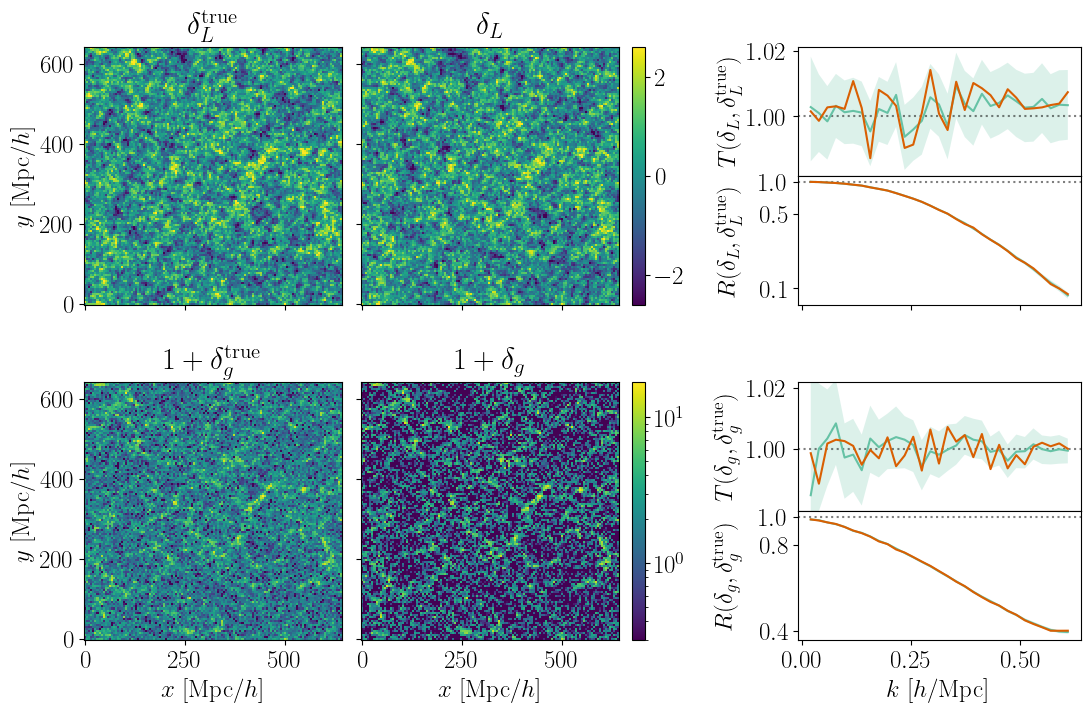

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
from montecosmo.plot import SetDark2_k
theme(dark=False, usetex=True, font_size=18, cmap="SetDark2")

def scalarformatter(n):
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    if isinstance(n, int):
        plt.gca().yaxis.set_major_locator(mpl.ticker.MaxNLocator(n))
        plt.gca().yaxis.set_minor_locator(mpl.ticker.MaxNLocator(n))
    else:
        plt.gca().yaxis.set_major_locator(mpl.ticker.FixedLocator(n))
        plt.gca().yaxis.set_minor_locator(mpl.ticker.FixedLocator([]))
        
 
    


# Create a figure
i_plt = 0
fig = plt.figure(figsize=(13.5, 7.7))

gs23 = GridSpec(2, 3, figure=fig, wspace=0.35, hspace=0.3)
gs21_13 = gs23[0, 2].subgridspec(2, 1, hspace=0)
gs21_23 = gs23[1, 2].subgridspec(2, 1, hspace=0)

gs12_11 = gs23[0, 0:2].subgridspec(1, 2, wspace=-0.1)
gs12_21 = gs23[1, 0:2].subgridspec(1, 2, wspace=-0.1)

# Add subplots to the inner grid
ax131 = fig.add_subplot(gs21_13[0])
ax132 = fig.add_subplot(gs21_13[1], sharex=ax131)
plt.setp(ax131.get_xticklabels(), visible=False)
plt.setp(ax132.get_xticklabels(), visible=False)

ax231 = fig.add_subplot(gs21_23[0])
ax232 = fig.add_subplot(gs21_23[1], sharex=ax231)
plt.setp(ax231.get_xticklabels(), visible=False)


ax11 = fig.add_subplot(gs12_11[0])
plt.setp(ax11.get_xticklabels(), visible=False)
ax12 = fig.add_subplot(gs12_11[1], sharey=ax11)
plt.setp(ax12.get_yticklabels(), visible=False)
plt.setp(ax12.get_xticklabels(), visible=False)
# ax112.set_yticks([])

ax21 = fig.add_subplot(gs12_21[0])
ax22 = fig.add_subplot(gs12_21[1], sharey=ax21)
plt.setp(ax22.get_yticklabels(), visible=False)




# Linear matter field
sli = 1
log = False
prob = 0.95
meshes1 = jnp.concatenate(chlin['init'])
alpha = (1-prob)**.5
# alpha = 0.5

plt.sca(ax11)
lim = 2.6
plot_mesh(mesh0, model.box_size, sli=5, axis=-2, vlim=(-lim, lim), cmap='viridis')
# plt.colorbar()
plt.xlabel(None)
plt.title('$ \\delta_L^\\mathrm{true}$', pad=10)

plt.sca(ax12)
means = meshes1[...,None][i_plt]
quad12 = plot_mesh(means, model.box_size, sli=sli, vlim=(-lim, lim), cmap='viridis')
plt.ylabel(None)
# plt.yticks([])
plt.xlabel(None)
plt.title('$\\delta_L$', pad=10)
plt.colorbar(ax=np.array([ax11, ax12]), pad=0.02, fraction=0.1)


plt.sca(ax131)
kptcs1 = tree.map(jnp.concatenate, chlin['kptc'])
kptc_med1 = tree.map(lambda x: jnp.median(x, 0), kptcs1)

plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_trans(kptc_med1[0], kptc_med1[2])
plot_trans(kptcs1[0], kptcs1[2], fill=prob, alpha=alpha)
line131, = plot_trans(kptcs1[0][i_plt], kptcs1[2][i_plt])
plt.ylabel('$T(\\delta_L, \\delta_L^\\mathrm{true})$')
plt.xlabel(None)
scalarformatter(2)

plt.sca(ax132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_med1[0], kptc_med1[3])
plot_coh(kptcs1[0], kptcs1[3], fill=prob, alpha=alpha)
line132, = plot_trans(kptcs1[0][i_plt], kptcs1[3][i_plt])
plt.ylabel('$R(\\delta_L, \\delta_L^\\mathrm{true})$', labelpad=12)
scalarformatter([1.0, 0.5, 0.1])
plt.xlabel(None)


# Galaxy density field
sli = 1
log = False
prob = 0.95
# meshes = jnp.concatenate(chbias['bias_mesh'])
meshes2 = jnp.concatenate(chobs['obs'])
# meshes = jnp.concatenate(chgxy['gxy_mesh'])
# meshes = jnp.concatenate(chgxytrue['gxy_mesh'])

vmin = 0.3
meshes2 = jnp.maximum(meshes2, vmin)
means = meshes2[...,None]
vmax = np.quantile(means, [1-1e-4/2])
means = means[i_plt]

plt.sca(ax21)
plot_mesh(jnp.maximum(truth['obs'], vmin), model.box_size, sli=5, axis=-2, cmap='viridis', vlim=(vmin,vmax), norm='log')
# plt.colorbar()
plt.title('$1+ \\delta_g^\\mathrm{true}$', pad=10)

plt.sca(ax22)
quad22 = plot_mesh(means, model.box_size, sli=sli, cmap='viridis', vlim=(vmin,vmax), norm='log')
plt.ylabel(None)
# plt.yticks([])
plt.title('$1+\\delta_g$', pad=10)
plt.colorbar(ax=np.array([ax21, ax22]), pad=0.02, fraction=0.1)

plt.sca(ax231)
kptcs2 = tree.map(jnp.concatenate, chobs['kptc'])
kptc_med2 = tree.map(lambda x: jnp.median(x, 0), kptcs2)

plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_trans(kptc_med2[0], kptc_med2[2])
plot_trans(kptcs2[0], kptcs2[2], fill=prob, alpha=alpha)
line231, = plot_trans(kptcs2[0][i_plt], kptcs2[2][i_plt])
plt.ylabel('$T(\\delta_g, \\delta_g^\\mathrm{true})$')
plt.xlabel(None)
plt.ylim(0.98, 1.022)
scalarformatter([1.0, 1.02])

plt.sca(ax232)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_med2[0], kptc_med2[3])
plot_coh(kptcs2[0], kptcs2[3], fill=prob, alpha=alpha)
line232, = plot_trans(kptcs2[0][i_plt], kptcs2[3][i_plt])
plt.ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$', labelpad=12)
# ax242.yaxis.set_label_position("right")
# ax242.set_ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$', rotation=270, labelpad=20)
scalarformatter([1.0, 0.8, 0.4])

# plt.savefig('post_fields4.png', dpi=500, bbox_inches='tight')
# plt.show()


thinning = 150
def update(i):
    quad12.set_array(meshes1[::2*thinning][i])
    quad22.set_array(meshes2[::thinning][i])

    kptc = tree.map(lambda x: x[::2*thinning][i], kptcs1)
    ks, pow, trans, coh = kptc
    line131.set_data(ks, trans)
    line132.set_data(ks, coh)

    kptc = tree.map(lambda x: x[::thinning][i], kptcs2)
    ks, pow, trans, coh = kptc
    line231.set_data(ks, trans)
    line232.set_data(ks, coh)
  
    return quad12, quad22, line131, line132, line231, line232


display(plt.gcf())
anim = FuncAnimation(plt.gcf(), update, frames=30, interval=100, blit=True)
# anim.save("chains.mp4", dpi=300)
# anim.save("chains.gif", dpi=300)
display(anim)
plt.close()

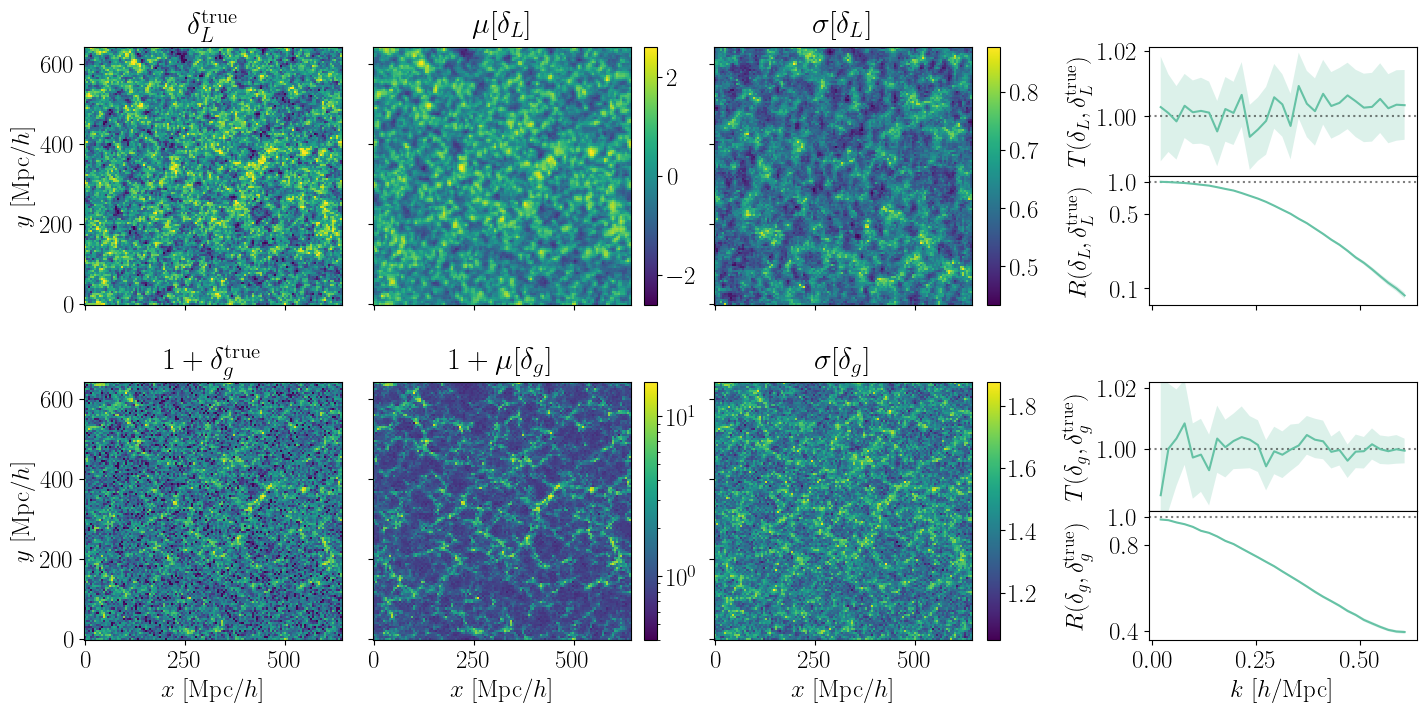

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
theme(usetex=True, font_size=18)

def scalarformatter(n):
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    if isinstance(n, int):
        plt.gca().yaxis.set_major_locator(mpl.ticker.MaxNLocator(n))
        plt.gca().yaxis.set_minor_locator(mpl.ticker.MaxNLocator(n))
    else:
        plt.gca().yaxis.set_major_locator(mpl.ticker.FixedLocator(n))
        plt.gca().yaxis.set_minor_locator(mpl.ticker.FixedLocator([]))
        

# Create a figure
fig = plt.figure(figsize=(18, 7.7))

gs24 = GridSpec(2, 4, figure=fig, wspace=0.4, hspace=0.3)
gs21_14 = gs24[0, 3].subgridspec(2, 1, hspace=0)
gs21_24 = gs24[1, 3].subgridspec(2, 1, hspace=0)

gs12_11 = gs24[0, 0:3].subgridspec(1, 3, wspace=-0.1)
gs12_21 = gs24[1, 0:3].subgridspec(1, 3, wspace=-0.1)

# Add subplots to the inner grid
ax141 = fig.add_subplot(gs21_14[0])
ax142 = fig.add_subplot(gs21_14[1], sharex=ax141)
plt.setp(ax141.get_xticklabels(), visible=False)
plt.setp(ax142.get_xticklabels(), visible=False)


ax241 = fig.add_subplot(gs21_24[0])
ax242 = fig.add_subplot(gs21_24[1], sharex=ax241)
plt.setp(ax241.get_xticklabels(), visible=False)

ax11 = fig.add_subplot(gs12_11[0])
plt.setp(ax11.get_xticklabels(), visible=False)
ax12 = fig.add_subplot(gs12_11[1], sharey=ax11)
plt.setp(ax12.get_yticklabels(), visible=False)
plt.setp(ax12.get_xticklabels(), visible=False)
# ax112.set_yticks([])
ax13 = fig.add_subplot(gs12_11[2], sharey=ax11)
plt.setp(ax13.get_yticklabels(), visible=False)
plt.setp(ax13.get_xticklabels(), visible=False)

ax21 = fig.add_subplot(gs12_21[0])
ax22 = fig.add_subplot(gs12_21[1], sharey=ax21)
plt.setp(ax22.get_yticklabels(), visible=False)
ax23 = fig.add_subplot(gs12_21[2], sharey=ax21)
plt.setp(ax23.get_yticklabels(), visible=False)




# Linear matter field
sli = 1
log = False
prob = 0.95
meshes = jnp.concatenate(chlin['init'])

plt.sca(ax11)
lim = 2.6
plot_mesh(mesh0, model.box_size, sli=5, axis=-2, vlim=(-lim, lim), cmap='viridis')
# plt.colorbar()
plt.xlabel(None)
plt.title('$ \\delta_L^\\mathrm{true}$', pad=10)

plt.sca(ax12)
means = meshes.mean(0)[...,None]
plot_mesh(means, model.box_size, sli=sli, vlim=(-lim, lim), cmap='viridis')
plt.ylabel(None)
# plt.yticks([])
plt.xlabel(None)
plt.title('$\\mu[\\delta_L]$', pad=10)
plt.colorbar(ax=np.array([ax11, ax12]), pad=0.02, fraction=0.1)

plt.sca(ax13)
stds = meshes.std(0)[...,None]
plot_mesh(stds, model.box_size, sli=sli, cmap='viridis')
plt.ylabel(None)
plt.xlabel(None)
plt.colorbar(pad=0.04)
plt.title('$\\sigma[\\delta_L]$', pad=10)

plt.sca(ax141)
kptcs = tree.map(jnp.concatenate, chlin['kptc'])
kptc_med = tree.map(lambda x: jnp.median(x, 0), kptcs)

plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_trans(kptc_med[0], kptc_med[2])
plot_trans(kptcs[0], kptcs[2], fill=prob)
plt.ylabel('$T(\\delta_L, \\delta_L^\\mathrm{true})$')
plt.xlabel(None)
scalarformatter(2)

plt.sca(ax142)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_med[0], kptc_med[3])
plot_coh(kptcs[0], kptcs[3], fill=prob)
plt.ylabel('$R(\\delta_L, \\delta_L^\\mathrm{true})$', labelpad=12)
scalarformatter([1.0, 0.5, 0.1])
plt.xlabel(None)


# Galaxy density field
sli = 1
log = False
prob = 0.95
# meshes = jnp.concatenate(chbias['bias_mesh'])
meshes = jnp.concatenate(chobs['obs'])
# meshes = jnp.concatenate(chgxy['gxy_mesh'])
# meshes = jnp.concatenate(chgxytrue['gxy_mesh'])

vmin = 0.4
means = jnp.maximum(meshes, vmin).mean(0)[...,None]
vmax = np.quantile(means, [1-1e-4/2])

plt.sca(ax21)
plot_mesh(jnp.maximum(truth['obs'], vmin), model.box_size, sli=5, axis=-2, cmap='viridis', vlim=(vmin,vmax), norm='log')
# plt.colorbar()
plt.title('$1+ \\delta_g^\\mathrm{true}$', pad=10)

plt.sca(ax22)
plot_mesh(means, model.box_size, sli=sli, cmap='viridis', vlim=(vmin,vmax), norm='log')
plt.ylabel(None)
# plt.yticks([])
plt.title('$1+\\mu[\\delta_g]$', pad=10)
plt.colorbar(ax=np.array([ax21, ax22]), pad=0.02, fraction=0.1)

plt.sca(ax23)
stds = meshes.std(0)[...,None]
plot_mesh(stds, model.box_size, sli=sli, cmap='viridis')
plt.ylabel(None)
plt.colorbar(pad=0.04)
plt.title('$\\sigma[\\delta_g]$', pad=10)

plt.sca(ax241)
kptcs = tree.map(jnp.concatenate, chobs['kptc'])
kptc_med = tree.map(lambda x: jnp.median(x, 0), kptcs)

plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_trans(kptc_med[0], kptc_med[2])
plot_trans(kptcs[0], kptcs[2], fill=prob)
plt.ylabel('$T(\\delta_g, \\delta_g^\\mathrm{true})$')
plt.xlabel(None)
plt.ylim(0.98, 1.022)
scalarformatter([1.0, 1.02])

plt.sca(ax242)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_med[0], kptc_med[3])
plot_coh(kptcs[0], kptcs[3], fill=prob)
plt.ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$', labelpad=12)
# ax242.yaxis.set_label_position("right")
# ax242.set_ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$', rotation=270, labelpad=20)
scalarformatter([1.0, 0.8, 0.4])

plt.savefig('post_fields4.png', dpi=500, bbox_inches='tight')
plt.show()

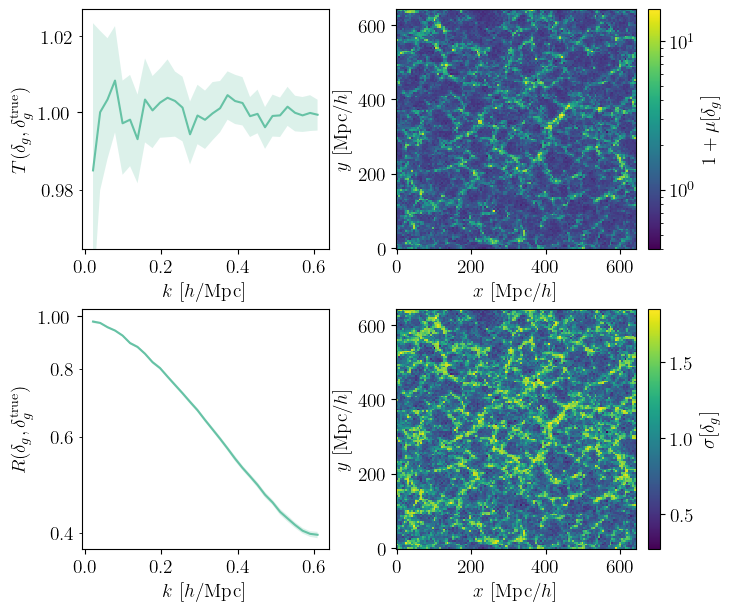

In [9]:
from montecosmo.plot import plot_powtranscoh, plot_coh, plot_trans, plot_pow, plot_mesh, theme, mean_slice, plot_bivar
from montecosmo.utils import vlim
from sklearn.neighbors import KernelDensity
from matplotlib.animation import FuncAnimation
theme(usetex=True, font_size=14)

sli = 1
log = False
prob = 0.95
# meshes = jnp.concatenate(chbias['bias_mesh'])
meshes = jnp.concatenate(chobs['obs'])
# meshes = jnp.concatenate(chgxy['gxy_mesh'])
# meshes = jnp.concatenate(chgxytrue['gxy_mesh'])

plt.figure(figsize=(7.2, 6), layout='constrained')
# plt.figure(figsize=(7, 6))
# plt.subplots_adjust(wspace=.3, hspace=0.3)

plt.subplot(222)
vmin = 0.4
# meshes = jnp.maximum(meshes + 1, vmin)
meshes = jnp.maximum(meshes, vmin)
means = meshes.mean(0)[...,None]
vmax = np.quantile(means, [1-1e-4/2])
quad2 = plot_mesh(means, model.box_size, sli=sli, cmap='viridis', vlim=(vmin,vmax), norm='log')
# quad2 = plot_mesh(means, model.box_size, sli=sli, cmap='viridis')
# plt.title('post mean')
# plt.colorbar(label='mean')
plt.colorbar(label='$1 + \\mu[\\delta_g]$')
# plt.colorbar(label='$\\mu[1+\\delta_g \\mid \\delta_g]$')


plt.subplot(224)
stds = meshes.std(0)[...,None]
vmax = np.quantile(stds, [1-1e-4/2])
# quad2 = plot_mesh(stds, model.box_size, sli=sli, cmap='viridis', vlim=(vmin,vmax), norm='log')
quad2 = plot_mesh(stds, model.box_size, sli=sli, cmap='viridis')
# plt.title('post std')
# plt.colorbar(label='std')
plt.colorbar(label='$\\sigma[\\delta_g]$')

# kptcs = tree.map(jnp.concatenate, chbias['kptc'])
kptcs = tree.map(jnp.concatenate, chobs['kptc'])
# kptcs = tree.map(jnp.concatenate, chgxy['kptc'])
# kptcs = tree.map(jnp.concatenate, chgxytrue['kptc'])
kptc_med = tree.map(lambda x: jnp.median(x, 0), kptcs)

plt.subplot(221)

plot_trans(kptc_med[0], kptc_med[2])
plot_trans(kptcs[0], kptcs[2], fill=prob)
plt.ylabel('$T(\\delta_g, \\delta_g^\\mathrm{true})$')
plt.ylim(0.965, plt.ylim()[1])
# plt.ylabel('$T(\\delta_L, \\delta_L^\\textrm{true})$')

import matplotlib as mpl
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
plt.gca().yaxis.set_minor_locator(mpl.ticker.MaxNLocator(4))


plt.subplot(223)
plot_coh(kptc_med[0], kptc_med[3])
plot_coh(kptcs[0], kptcs[3], fill=prob)
# plot_coh(kptc_obs[0], kptc_obs[3], ':', log=log, c='grey', label='obs')

# plt.ylabel('$| R(\\delta_L, \\delta_L^{\\rm{true}})|$')
# plt.ylabel('spectral correlation');
plt.ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$')

import matplotlib as mpl
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
plt.gca().yaxis.set_minor_locator(mpl.ticker.MaxNLocator(4))
# plt.savefig(f'post_gxyfield5.pdf', bbox_inches='tight')
# plt.savefig(f'post_gxyfield5.png', dpi=300, bbox_inches='tight')
# # plt.savefig(f'post_gxytruefield5.pdf', bbox_inches='tight')
# plt.savefig(f'post_gxytruefield5.png', dpi=300, bbox_inches='tight')
plt.savefig(f'post_obsfieldz5.pdf', bbox_inches='tight')
plt.savefig(f'post_obsfield5z.png', dpi=300, bbox_inches='tight')

## Cubes

In [11]:
from montecosmo.chains import Chains
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_mesh, plot_trans, plot_coh, theme, SetDark2

model = FieldLevelModel(**default_config | {'box_size': 3*(1280,), 'mesh_shape': 3* (32,)})
truth = {'Omega_m': 0.3, 
        'sigma8': 0.8, 
        'b1': 1.,
        'b2':0., 
        'bs2':0., 
        'bn2': 0.}

truth = model.predict(samples=truth, hide_base=False, hide_samp=False, hide_det=True, from_base=True)
mesh = np.array(truth['obs'])

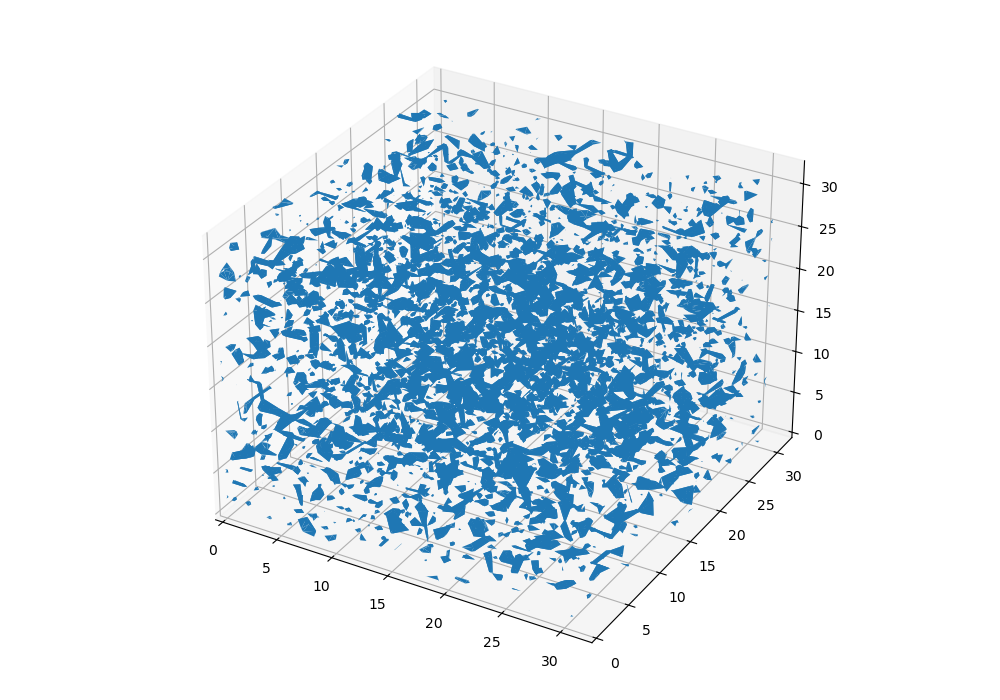

In [21]:
%matplotlib widget
from skimage.measure import marching_cubes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
verts, faces, normals, values = marching_cubes(mesh, level=0.2)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2], cmap='viridis')
mesh3d = Poly3DCollection(verts[faces])
# mesh3d.set_edgecolor('k')
ax.add_collection3d(mesh3d)

n = len(mesh)
ax.set_xlim(0, n)
ax.set_ylim(0, n)
ax.set_zlim(0, n)

plt.tight_layout()
plt.show()